# Wasserstein GAN with Gradient Penalty (WGAN-GP)

This notebook implements a self-contained WGAN-GP based on the [EmilienDupont/wgan-gp](https://github.com/EmilienDupont/wgan-gp) repository.

## Key Features:
- **Likelihood-free training**: Uses adversarial learning instead of maximum likelihood
- **Wasserstein distance**: More stable training than standard GANs
- **Gradient penalty**: Enforces Lipschitz constraint on discriminator
- **MNIST dataset**: Demonstrates image generation capabilities

## Why WGAN-GP is Likelihood-Free:
Unlike maximum likelihood estimation, WGAN-GP doesn't require:
- Invertible generator functions
- Computable Jacobian determinants
- Direct density estimation

Instead, it uses a discriminator (critic) to learn the Wasserstein distance between real and generated distributions.


In [ ]:
# Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


Using device: cuda


## Model Definitions

### Generator Network
The generator transforms noise $z \sim \mathcal{N}(0, I)$ into images that should match the real data distribution.


In [ ]:
class Generator(nn.Module):
    def __init__(self, img_size=(32, 32, 1), latent_dim=100, dim=16):
        super(Generator, self).__init__()

        self.img_size = img_size
        self.latent_dim = latent_dim

        # Calculate the size after upsampling
        self.init_size = img_size[0] // 4

        # Initial linear layer
        self.l1 = nn.Linear(latent_dim, dim * 2 * self.init_size * self.init_size)

        # Convolutional layers
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(dim * 2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(dim * 2, dim, 3, stride=1, padding=1),
            nn.BatchNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(dim, img_size[2], 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], -1, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


### Discriminator (Critic) Network

The discriminator acts as a **Lipschitz function** that estimates the Wasserstein distance between real and generated distributions. This is the key to likelihood-free training!


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_size=(32, 32, 1), dim=16):
        super(Discriminator, self).__init__()

        self.img_size = img_size

        # Convolutional layers
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(img_size[2], dim, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dim, dim * 2, 3, 2, 1),
            nn.BatchNorm2d(dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dim * 2, dim * 4, 3, 2, 1),
            nn.BatchNorm2d(dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Calculate output size
        conv_out_size = self._get_conv_out_size()

        # Final linear layer
        self.fc = nn.Linear(conv_out_size, 1)

    def _get_conv_out_size(self):
        dummy_input = torch.zeros(1, self.img_size[2], self.img_size[0], self.img_size[1])
        dummy_output = self.conv_blocks(dummy_input)
        return int(np.prod(dummy_output.size()))

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out


## WGAN-GP Loss Functions


In [ ]:
def gradient_penalty(discriminator, real_samples, fake_samples, device):
    """
    Compute gradient penalty to enforce Lipschitz constraint.
    This is crucial for stable WGAN training!
    """
    batch_size = real_samples.size(0)

    # Random interpolation between real and fake samples
    alpha = torch.rand(batch_size, 1, 1, 1).to(device)
    interpolated = alpha * real_samples + (1 - alpha) * fake_samples
    interpolated.requires_grad_(True)

    # Get discriminator output for interpolated samples
    d_interpolated = discriminator(interpolated)

    # Compute gradients
    gradients = torch.autograd.grad(
        outputs=d_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones_like(d_interpolated).to(device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Compute gradient penalty
    gradients = gradients.view(batch_size, -1)
    gradient_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
    penalty = torch.mean((gradient_norm - 1) ** 2)

    return penalty

def wgan_gp_loss(discriminator, real_samples, fake_samples, lambda_gp=10, device='cpu'):
    """
    WGAN-GP loss function.

    This is the likelihood-free objective that replaces MLE!
    """
    # Real samples loss
    real_loss = torch.mean(discriminator(real_samples))

    # Fake samples loss
    fake_loss = torch.mean(discriminator(fake_samples))

    # Gradient penalty
    gp = gradient_penalty(discriminator, real_samples, fake_samples, device)

    # Total discriminator loss
    d_loss = fake_loss - real_loss + lambda_gp * gp

    return d_loss, gp


## Data Loading

We'll use MNIST dataset to demonstrate the WGAN-GP training.


In [ ]:
# Data loading and preprocessing
def get_mnist_dataloader(batch_size=64, img_size=32):
    """
    Load MNIST dataset with proper preprocessing for WGAN-GP
    """
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])

    dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    return dataloader

# Load data
batch_size = 64
img_size = 32
latent_dim = 100
dataloader = get_mnist_dataloader(batch_size, img_size)

print(f"Dataset loaded: {len(dataloader)} batches")
print(f"Batch size: {batch_size}")
print(f"Image size: {img_size}x{img_size}")


100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 339kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.2MB/s]

Dataset loaded: 938 batches
Batch size: 64
Image size: 32x32


## Model Initialization

Initialize the generator and discriminator networks.


In [ ]:
# Initialize models
generator = Generator(img_size=(img_size, img_size, 1), latent_dim=latent_dim, dim=16).to(device)
discriminator = Discriminator(img_size=(img_size, img_size, 1), dim=16).to(device)

# Initialize optimizers
lr = 1e-4
beta1, beta2 = 0.5, 0.999

G_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
D_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

# Print model info
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Generator parameters: {count_parameters(generator):,}")
print(f"Discriminator parameters: {count_parameters(discriminator):,}")
print(f"Total parameters: {count_parameters(generator) + count_parameters(discriminator):,}")


Generator parameters: 211,713
Discriminator parameters: 24,513
Total parameters: 236,226


## Training Loop

### Key Training Insights:

1. **Likelihood-Free**: No need to compute $p_\theta(x)$ or Jacobian determinants
2. **Adversarial Training**: Generator and discriminator compete
3. **Gradient Penalty**: Enforces Lipschitz constraint for stable training
4. **Multiple D Updates**: Train discriminator more frequently than generator



LIKELIHOOD-FREE TRAINING DEMONSTRATION

Key Points:
• No likelihood computation required
• No invertibility constraints
• Uses Wasserstein distance via discriminator
• Gradient penalty enforces Lipschitz constraint

Starting training...
Starting WGAN-GP training...
This demonstrates likelihood-free learning!


Epoch 1/50: 100%|██████████| 938/938 [01:04<00:00, 14.50it/s, G_Loss=2957.5142, D_Loss=-6133.0615, GP=2.6619]


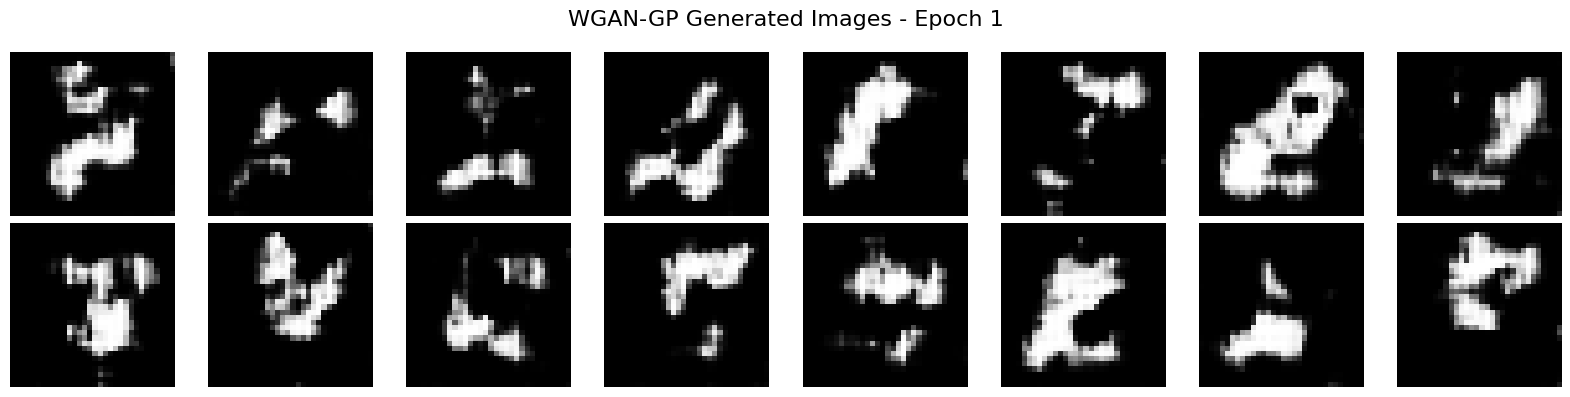

Epoch 1: G_Loss=2299.1114, D_Loss=-4701.4531, GP=7.4940


Epoch 2/50: 100%|██████████| 938/938 [01:04<00:00, 14.65it/s, G_Loss=4451.0137, D_Loss=-9385.6738, GP=5.7597]


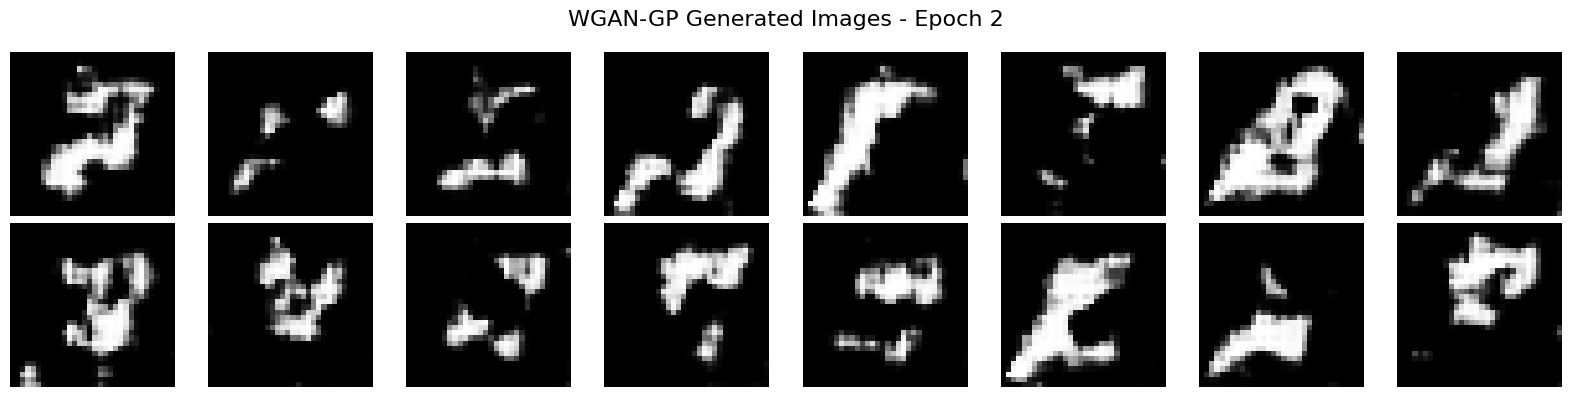

Epoch 2: G_Loss=3618.3931, D_Loss=-7631.8187, GP=6.9605


Epoch 3/50: 100%|██████████| 938/938 [01:05<00:00, 14.26it/s, G_Loss=2233.0999, D_Loss=-8927.5762, GP=41.1296]


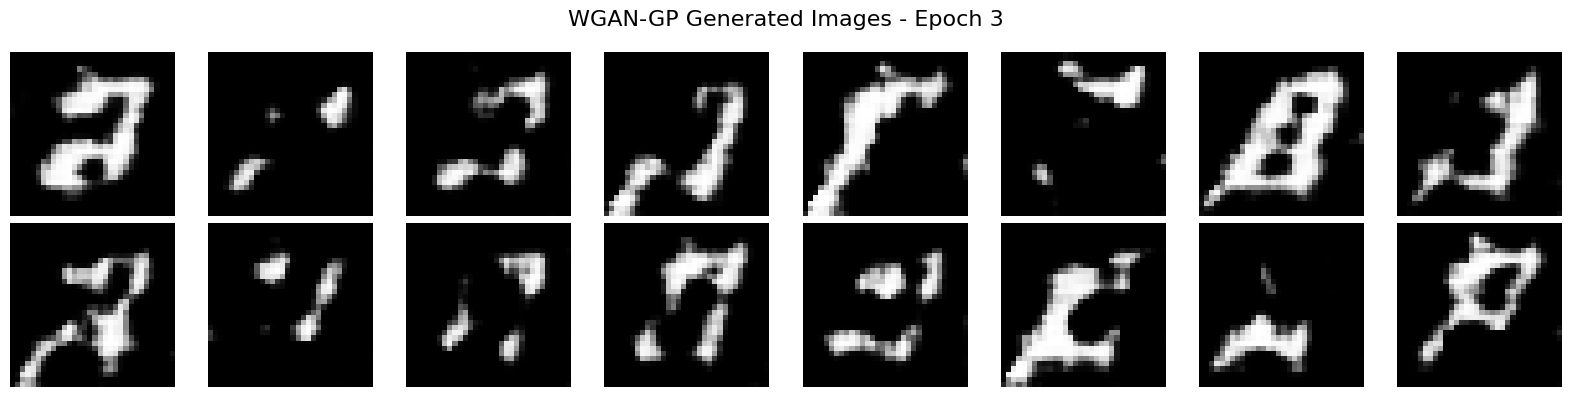

Epoch 3: G_Loss=5166.5485, D_Loss=-10882.1805, GP=14.1928


Epoch 4/50:  50%|█████     | 469/938 [00:32<00:32, 14.22it/s, G_Loss=6679.9248, D_Loss=-14662.8975, GP=22.5568]


KeyboardInterrupt: 

In [ ]:
def train_wgan_gp(generator, discriminator, dataloader, epochs=50, n_critic=5, lambda_gp=10):
    """
    Train WGAN-GP model.

    This demonstrates likelihood-free training!
    """

    # Training history
    g_losses = []
    d_losses = []
    gp_losses = []

    # Fixed noise for visualization
    fixed_noise = torch.randn(16, latent_dim).to(device)

    print("Starting WGAN-GP training...")
    print("This demonstrates likelihood-free learning!")

    for epoch in range(epochs):
        epoch_g_loss = 0
        epoch_d_loss = 0
        epoch_gp_loss = 0

        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}')

        # Show generated sample images
        if (epoch + 1) % 1 == 0:
            with torch.no_grad():
                sample_images = generator(fixed_noise)

            # Plot sample images
            fig, axes = plt.subplots(2, 8, figsize=(16, 4))
            for i in range(16):
                row, col = i // 8, i % 8
                img = sample_images[i].cpu().squeeze()
                axes[row, col].imshow(img, cmap='gray')
                axes[row, col].axis('off')

            plt.suptitle(f'WGAN-GP Generated Images - Epoch {epoch+1}', fontsize=16)
            plt.tight_layout()
            plt.show()

        for batch_idx, (real_images, _) in enumerate(progress_bar):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # ===== Train Discriminator (Critic) =====
            for _ in range(n_critic):
                # Generate fake images
                noise = torch.randn(batch_size, latent_dim).to(device)
                fake_images = generator(noise)

                # Compute WGAN-GP loss
                d_loss, gp_loss = wgan_gp_loss(
                    discriminator, real_images, fake_images, lambda_gp, device
                )

                # Update discriminator
                D_optimizer.zero_grad()
                d_loss.backward()
                D_optimizer.step()

                epoch_d_loss += d_loss.item()
                epoch_gp_loss += gp_loss.item()

            # ===== Train Generator =====
            noise = torch.randn(batch_size, latent_dim).to(device)
            fake_images = generator(noise)

            # Generator loss (negative discriminator output)
            g_loss = -torch.mean(discriminator(fake_images))

            # Update generator
            G_optimizer.zero_grad()
            g_loss.backward()
            G_optimizer.step()

            epoch_g_loss += g_loss.item()

            # Update progress bar
            progress_bar.set_postfix({
                'G_Loss': f'{g_loss.item():.4f}',
                'D_Loss': f'{d_loss.item():.4f}',
                'GP': f'{gp_loss.item():.4f}'
            })

        # Store losses
        g_losses.append(epoch_g_loss / len(dataloader))
        d_losses.append(epoch_d_loss / (len(dataloader) * n_critic))
        gp_losses.append(epoch_gp_loss / (len(dataloader) * n_critic))


            print(f"Epoch {epoch+1}: G_Loss={g_losses[-1]:.4f}, D_Loss={d_losses[-1]:.4f}, GP={gp_losses[-1]:.4f}")

    return g_losses, d_losses, gp_losses

# Start training
print("\n" + "="*60)
print("LIKELIHOOD-FREE TRAINING DEMONSTRATION")
print("="*60)
print("\nKey Points:")
print("• No likelihood computation required")
print("• No invertibility constraints")
print("• Uses Wasserstein distance via discriminator")
print("• Gradient penalty enforces Lipschitz constraint")
print("\nStarting training...")

# Train the model
g_losses, d_losses, gp_losses = train_wgan_gp(
    generator, discriminator, dataloader,
    epochs=50, n_critic=5, lambda_gp=10
)


In [ ]:
noise = torch.randn(batch_size, latent_dim).to(device)
fake_images = generator(noise)
# Plot sample images
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(16):
    row, col = i // 8, i % 8
    img = sample_images[i].cpu().squeeze()
    axes[row, col].imshow(img, cmap='gray')
    axes[row, col].axis('off')

NameError: name 'torch' is not defined